In [1]:
import torch
import torchvision
import json
import jieba
import time
import gensim
import numpy as np
from torch import nn, optim
from numpy import math
from gensim.models import word2vec as word
from torchtext import data as Data
from torchtext.vocab import Vectors
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = 'E:\Jason\Documents\深度学习\实验五\dataset'
stopwords = [line.strip() for line in open('stopword.txt', 'r', encoding='utf-8').readlines()]

lr = 1e-4
batch_size = 64
sentence_len = 50
embedding_size = 100
num_classes = 6
num_epoches = 50

## 1 词向量训练

In [2]:
# 读取数据
with open(data_dir+'/virus_train.txt','r', encoding='utf-8') as load_file:
    load_file = json.load(load_file)
    train_valid_split = 6606
    load_train = load_file[:train_valid_split]
    load_valid = load_file[train_valid_split:]
    print('train: %d, valid: %d' % (len(load_train), len(load_valid)))
with open(data_dir+'/virus_eval_labeled.txt', 'r', encoding='utf-8') as load_file:
    load_test = json.load(load_file)
    print('test: %d' % (len(load_test)))
load_file.close()

train: 6606, valid: 2000
test: 2000


In [3]:
# 分词(运行一次即可，保存至本地)
# for sentence in load_train:
#     word_cut = jieba.cut(sentence['content'])
#     for words in word_cut:
#         if words not in stopwords:
#             if words != '\t':
#                 result = words + ' '
#                 result = result.encode('utf-8')
#                 with open('word_cut.txt', 'ab') as save_file:
#                     save_file.write(result)
# save_file.close()

# 不去停用词版
# for sentence in load_train:
#     word_cut = jieba.cut(sentence['content'])
#     result = ' '.join(word_cut)
#     result = result.encode('utf-8')
#     with open('word_cut_nonestop.txt', 'ab') as save_file:
#         save_file.write(result)
# save_file.close()

In [4]:
# 训练词向量(运行一次即可，保存至本地)
# sentences = word.LineSentence('word_cut.txt')
# model = word.Word2Vec(sentences, hs=1, min_count=1, window=3, size=embedding_size)
# model.save("w2vmodel")
# model.wv.save_word2vec_format('w2vformat.txt', binary=False)

## 2 数据预处理

max: 3172, mean: 54.7649


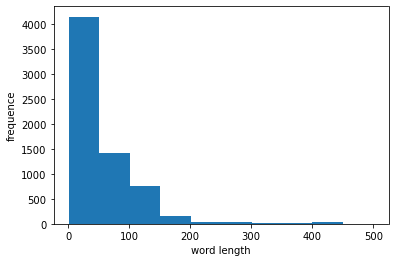

In [5]:
content = []
total = 0
n = 0
for datas in load_train:
    content.append(len(datas['content']))
    total += len(datas['content'])
    n += 1
content = sorted(content)
print('max: %d, mean: %.4f' % (content[-1], total/n))

plt.hist(content, range=(1,500))
plt.xlabel("word length")
plt.ylabel("frequence")
plt.show()

In [6]:
# 分词，并去除停用词
def words_after_jieba(X):
    sentence = jieba.cut(X)
    words = []
    for word in sentence:
        if word not in stopwords:
            if word != '\t':
                words.append(word)
    return words

# # 分词，不去停用词版
# def words_after_jieba(X):
#     sentence = jieba.lcut(X)
#     return sentence

# 转换标签
def trans_labels(y):
    label_dict = {'neural':0, 'happy':1, 'angry':2, 'sad':3, 'fear':4, 'surprise':5}
    return label_dict[y]

In [7]:
# 构造数据集
TEXT = Data.Field(fix_length=sentence_len, batch_first=True)
LABEL = Data.LabelField(dtype=torch.float)

def get_dataset(load_data, text_field, label_field):
    fields = [('text', text_field), ('label', label_field)]
    examples = []

    for data in load_data:
        content = words_after_jieba(data['content'])
        label = trans_labels(data['label'])
        examples.append(Data.Example.fromlist([content, label], fields))

    return examples, fields

train_examples, train_fields = get_dataset(load_train, TEXT, LABEL)
valid_examples, valid_fields = get_dataset(load_valid, TEXT, LABEL)
test_examples, test_fields = get_dataset(load_test, TEXT, LABEL)

train_set = Data.Dataset(train_examples, train_fields)
valid_set = Data.Dataset(valid_examples, valid_fields)
test_set = Data.Dataset(test_examples, test_fields)

# 根据词向量建立词表
TEXT.build_vocab(train_set, vectors=Vectors('w2vformat.txt'))
LABEL.build_vocab(train_set)

train_iter = Data.BucketIterator(train_set, batch_size, sort=False, device=device)
valid_iter = Data.BucketIterator(valid_set, batch_size, sort=False, device=device)
test_iter = Data.BucketIterator(test_set, batch_size, sort=False, device=device)

# print(next(iter(train_iter)).text.shape)     
# print(next(iter(train_iter)).label.shape)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Jason\AppData\Local\Temp\jieba.cache
Loading model cost 0.626 seconds.
Prefix dict has been built successfully.


## 3 构建TextCNN网络

In [8]:
# 定义模型
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size,
                 filter_num=100, kernel_list=(2,3,4), dropout=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Sequential(
                nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                nn.ReLU(),
                nn.MaxPool2d((sentence_len-kernel+1, 1))
            ) for kernel in kernel_list]
        )
        self.fc = nn.Linear(filter_num * len(kernel_list), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x) # (batch_size, word_num, embedding_dim)
        x = x.unsqueeze(1) # (batch_size, channel_num, word_num, embedding_dim)
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1)
        out = out.view(x.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

In [9]:
# 训练函数
def train_epoch(net, iterator, optimizer, criterion):
    train_batch_num = len(iterator)
    total_loss = 0
    net.train()

    for i, batch in enumerate(iterator):
        pred = net(batch.text)
        loss = criterion(pred, batch.label.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / train_batch_num
    return avg_loss

In [10]:
# 测试函数
def test_epoch(net, iterator, criterion):
    test_batch_num = len(iterator)
    total_loss, macro_p, macro_r, macro_f1 = 0, 0, 0, 0
    net.eval()

    with torch.no_grad():
        for i, batch in enumerate(iterator):
            pred = net(batch.text)
            loss = criterion(pred, batch.label.long())
            
            total_loss += loss.item()
            true_label = batch.label.cpu().numpy()
            pred_label = pred.argmax(dim=1).cpu().numpy()
            macro_p += precision_score(true_label, pred_label, average='macro')
            macro_r += recall_score(true_label, pred_label, average='macro')
            macro_f1 += f1_score(true_label, pred_label, average='macro')

    avg_loss = total_loss / test_batch_num
    avg_p = macro_p / test_batch_num
    avg_r = macro_r / test_batch_num
    avg_f1 = macro_f1 / test_batch_num
    return avg_loss, avg_p, avg_r, avg_f1

In [11]:
# 使用模型
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

net = TextCNN(len(TEXT.vocab), embedding_size, num_classes).to(device)
pretrained_embedding = TEXT.vocab.vectors
net.embedding.weight.data.copy_(pretrained_embedding)
net.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_size)
net.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_size)

optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loss_list = []
# valid_loss_list, valid_p_list, valid_r_list, valid_f1_list = [], [], [], []
test_loss_list, test_p_list, test_r_list, test_f1_list = [], [], [], []
for epoch in range(num_epoches):
    train_loss= train_epoch(net, train_iter, optimizer, criterion)
    # valid_loss, valid_p, valid_r, valid_f1 = test_epoch(net, valid_iter, criterion)
    test_loss, test_p, test_r, test_f1 = test_epoch(net, test_iter, criterion)
    
    train_loss_list.append(train_loss)
    # valid_loss_list.append(valid_loss)
    # valid_p_list.append(valid_p)
    # valid_r_list.append(valid_r)
    # valid_f1_list.append(valid_f1)
    test_loss_list.append(test_loss)
    test_p_list.append(test_p)
    test_r_list.append(test_r)
    test_f1_list.append(test_f1)

    # print('epoch: %d, train loss: %.4f, valid loss: %.4f, valid p: %.4f, valid r: %.4f, valid f1: %.4f' % (epoch+1, train_loss, valid_loss, valid_p, valid_r, valid_f1))
    print('epoch: %d, train loss: %.4f, test loss: %.4f, test p: %.4f, test r: %.4f, test f1: %.4f' % (epoch+1, train_loss, test_loss, test_p, test_r, test_f1))

epoch: 1, train loss: 1.3082, test loss: 1.2881, test p: 0.2613, test r: 0.2475, test f1: 0.2253
epoch: 2, train loss: 1.1287, test loss: 1.2255, test p: 0.2573, test r: 0.2818, test f1: 0.2570
epoch: 3, train loss: 1.0784, test loss: 1.2003, test p: 0.3169, test r: 0.3161, test f1: 0.2941
epoch: 4, train loss: 1.0469, test loss: 1.1815, test p: 0.3394, test r: 0.3240, test f1: 0.3077
epoch: 5, train loss: 1.0269, test loss: 1.1694, test p: 0.3283, test r: 0.3174, test f1: 0.2971
epoch: 6, train loss: 1.0068, test loss: 1.1511, test p: 0.3531, test r: 0.3304, test f1: 0.3176
epoch: 7, train loss: 0.9915, test loss: 1.1379, test p: 0.3662, test r: 0.3407, test f1: 0.3315
epoch: 8, train loss: 0.9722, test loss: 1.1361, test p: 0.3678, test r: 0.3524, test f1: 0.3358
epoch: 9, train loss: 0.9626, test loss: 1.1131, test p: 0.3723, test r: 0.3565, test f1: 0.3408
epoch: 10, train loss: 0.9516, test loss: 1.1253, test p: 0.3701, test r: 0.3391, test f1: 0.3268
epoch: 11, train loss: 0.9436

## 4 结果展示

In [12]:
# 训练/验证loss
# plt.title("The loss of TextCNN")
# plt.xlabel("epoches")
# plt.ylabel("loss")
# plt.plot(range(1, num_epoches+1), train_loss_list)
# plt.plot(range(1, num_epoches+1), valid_loss_list)
# plt.legend(["train", "valid"])
# plt.show()

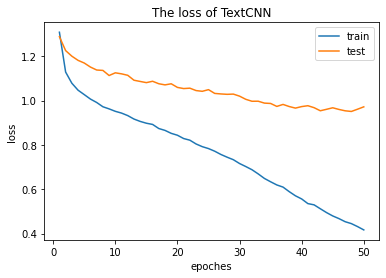

In [24]:
# 训练/测试loss
plt.title("The loss of TextCNN")
plt.xlabel("epoches")
plt.ylabel("loss")
plt.plot(range(1, num_epoches+1), train_loss_list)
plt.plot(range(1, num_epoches+1), test_loss_list)
plt.legend(["train", "test"])
plt.show()

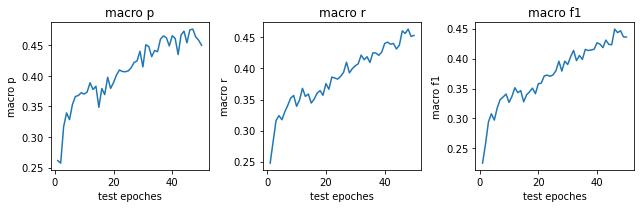

In [14]:
# 指标评价
def semilogy(x_vals, y_vals, x_labels, y_labels, titles):
    fig = plt.figure(figsize=(9, 3))
    for i in range(len(x_vals)):
        ax = fig.add_subplot(1, 3, i+1)
        ax.set_title(titles[i])
        ax.set_xlabel(x_labels[i])
        ax.set_ylabel(y_labels[i])
        ax.plot(x_vals[i], y_vals[i], '-')
    fig.tight_layout()
    plt.show()

x_vals = [range(1, num_epoches+1), range(1, num_epoches+1), range(1, num_epoches+1)]
# y_vals = [valid_p_list, valid_r_list, valid_f1_list]
y_vals = [test_p_list, test_r_list, test_f1_list]
x_labels = ['test epoches', 'test epoches', 'test epoches']
y_labels = ['macro p', 'macro r', 'macro f1']
titles = ['macro p', 'macro r', 'macro f1']

semilogy(x_vals, y_vals, x_labels, y_labels, titles)

In [27]:
# 预测结果
def get_labels(labels):
    text_labels = ['neural', 'happy', 'angry', 'sad', 'fear', 'surprise']
    return [text_labels[int(i)] for i in labels]

X, y = next(iter(test_iter))
true_labels = get_labels(y.cpu().numpy())
pred_labels = get_labels(net(X).argmax(dim=1).cpu().numpy())

for i in range(10):
    result = "-> false" if true_labels[i]!=pred_labels[i] else ""
    print('true label: %s, pred label: %s %s' % (true_labels[i], pred_labels[i], result))

true label: neural, pred label: angry -> false
true label: angry, pred label: angry 
true label: happy, pred label: happy 
true label: neural, pred label: happy -> false
true label: happy, pred label: happy 
true label: happy, pred label: angry -> false
true label: neural, pred label: neural 
true label: angry, pred label: neural -> false
true label: neural, pred label: neural 
true label: happy, pred label: happy 


In [16]:
print(net)

TextCNN(
  (embedding): Embedding(17770, 100)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 100, kernel_size=(2, 100), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(49, 1), stride=(49, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(48, 1), stride=(48, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(47, 1), stride=(47, 1), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc): Linear(in_features=300, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
